# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [112]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [113]:
# explore the portfolio
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [114]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    portfolio['duration'] = portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # drop the channels and offer_type column
    portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)
    
    return portfolio

In [115]:
portfolio = clean_portfolio(portfolio)

In [116]:
portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [4]:
# explore the profile 
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [16]:
profile.shape

(17000, 5)

In [44]:
# age: (numeric) missing value encoded as 118
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

In [41]:
profile.dropna(inplace=True)

In [55]:
import datetime

In [65]:
datetime.datetime.today()

datetime.datetime(2019, 5, 26, 10, 45, 32, 615604)

In [70]:
profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date

1        680 days
3        747 days
5        395 days
8        471 days
12       561 days
13       622 days
14      1928 days
15      1200 days
16      1655 days
18       511 days
19       390 days
20      1117 days
21       624 days
22       709 days
24      2114 days
25       393 days
27       607 days
28       622 days
29      1586 days
30      1737 days
31       617 days
32       608 days
33       555 days
34      1051 days
35      1015 days
37      1841 days
38       652 days
40      1291 days
41      1049 days
42       323 days
           ...   
16963    864 days
16964    413 days
16965    412 days
16966   1581 days
16967   1430 days
16968    670 days
16970   1296 days
16971    369 days
16972    857 days
16973   1322 days
16974   1229 days
16975    511 days
16976    977 days
16978    825 days
16979   2072 days
16981   1061 days
16983   1513 days
16984   1044 days
16985    341 days
16986    664 days
16987   1051 days
16988    507 days
16990   1172 days
16992    616 days
16993    3

In [72]:
profile['memberdays'] = profile['memberdays'].dt.days

In [73]:
profile.describe()

,age,became_member_on,income,memberdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,826.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,304.000000
25%,42.000000,2.016052e+07,49000.000000,512.000000
50%,55.000000,2.017080e+07,64000.000000,662.000000
75%,66.000000,2.017123e+07,80000.000000,1101.000000
max,101.000000,2.018073e+07,120000.000000,2127.000000


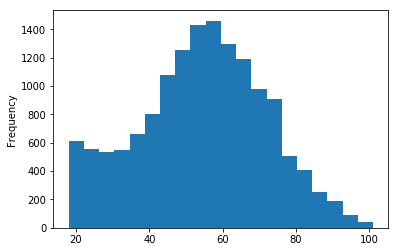

In [53]:
profile['age'].plot(kind='hist', bins=20)

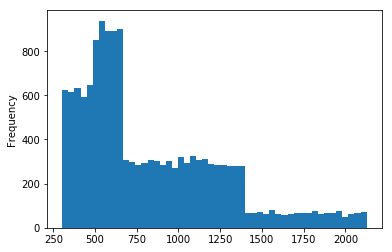

In [75]:
profile['memberdays'].plot(kind='hist', bins=50)

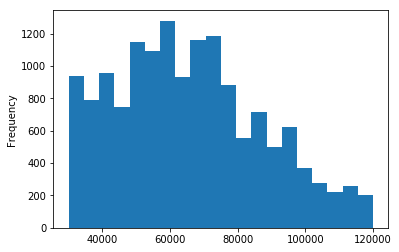

In [79]:
profile['income'].plot(kind='hist', bins=20)

In [43]:
profile.head()

,age,became_member_on,gender,id,income
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [8]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript[transcript['person']=='68be06ca386d4c31939f3a4f0e3dd783']

,event,person,time,value
53174,offer received,68be06ca386d4c31939f3a4f0e3dd783,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
85290,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
110828,offer received,68be06ca386d4c31939f3a4f0e3dd783,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
130147,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
135224,transaction,68be06ca386d4c31939f3a4f0e3dd783,360,{'amount': 0.35000000000000003}
150596,offer received,68be06ca386d4c31939f3a4f0e3dd783,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
163374,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
167626,transaction,68be06ca386d4c31939f3a4f0e3dd783,414,{'amount': 0.74}
182544,transaction,68be06ca386d4c31939f3a4f0e3dd783,444,{'amount': 1.8900000000000001}
201570,offer received,68be06ca386d4c31939f3a4f0e3dd783,504,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


In [125]:
offer = transcript[transcript['value'].apply(lambda x: True if 'offer id' in x else False)]

In [138]:
offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [143]:
offer.groupby(['person', 'offer_id'])['event'].count().unstack()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,2.0,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,2.0,2.0,NaN,1.0,NaN,3.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,2.0,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN
003d66b6608740288d6cc97a6903f4f0,1.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,4.0
00426fe3ffde4c6b9cb9ad6d077a13ea,1.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,2.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,4.0
